# Calculating DRT

This package estimates DRT by generating a Voigt circuit model and fitting its parameters using `LsqFit.jl`. The concept can be broken down simply: any impedance $Z(\omega)$ can be generated by a series of RC pairs:
$$
Z(\omega) = \sum_i^\infty \frac{R_i}{1+i\omega\tau_i},\\ \tau_i = R_iC_i
$$
This is analogous to a fourier transform for generic functions. Let's look at some examples.

In [2]:
using EISAnalysis

First, let's consider a simple circuit with 2 RC pairs

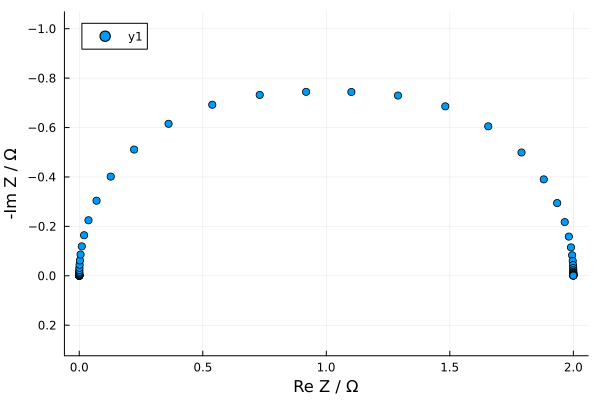

In [3]:
rc_circuit = r/0.1c-r/0.5c
plot_Nyquist(rc_circuit)

Now if we fit this to a Voigt circuit and estimate the DRT,

Regularizaiton Not Used
rtol = 8.578217720699712e-5


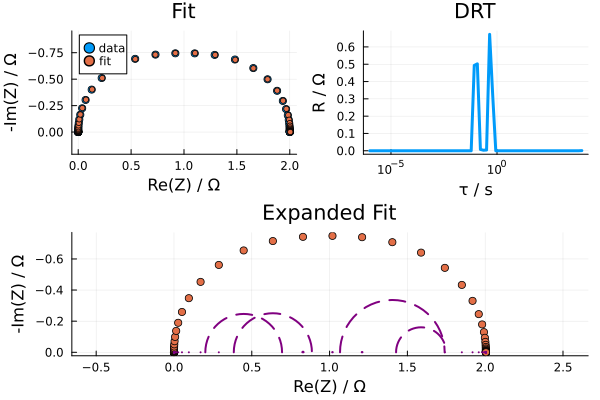

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[1.09364e-8-0.000121622im, 2.11149e-8-0.000168994im, 4.076…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0
  "drt" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0,…

In [9]:
rc_fit = compute_drt(rc_circuit.ω,rc_circuit.Z;ppd=7)

Now let's see what happens if we use CPE's instead

rtol = 6.354902972726497e-15


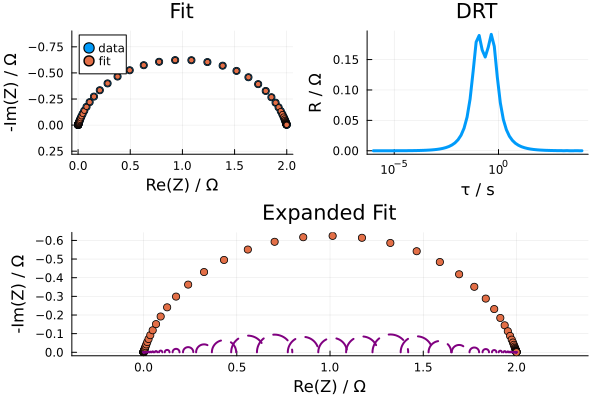

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.000249126-0.000765413im, 0.000324255-0.000995722im, 0.0…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 1.30978e-5
  "drt" => [1.80389e-5, 2.51794e-5, 0.0, 2.04385e-5, 1.89408e-5, 3.52985e-5, 3.…

In [5]:
rq_circuit = r/0.1q-r/0.5q
rq_fit = compute_drt(rq_circuit.ω,rq_circuit.Z)

Now for more complicated circuits

rtol = 3.016339194958138e-6


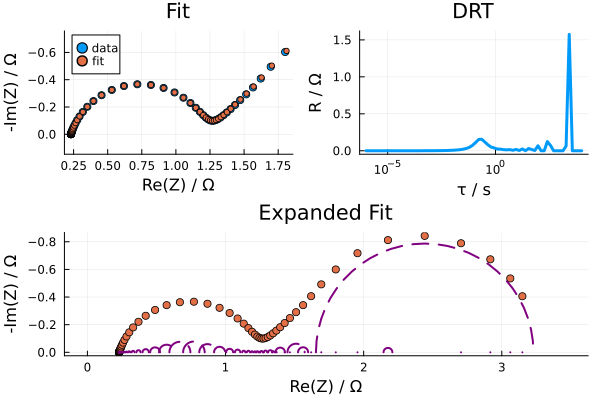

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.230112-0.000344577im, 0.230146-0.000448272im, 0.23019-0…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.230006
  "drt" => [8.67132e-7, 2.30287e-5, 1.73049e-8, 4.31068e-6, 6.5205e-7, 3.35715e…

In [6]:
randles_circuit = 0.23r-(r-0.025ws^80)/0.2q
randles_fit = compute_drt(randles_circuit.ω,randles_circuit.Z)

Now let's try to fit to experimental data. I found this dataset on Mendeley

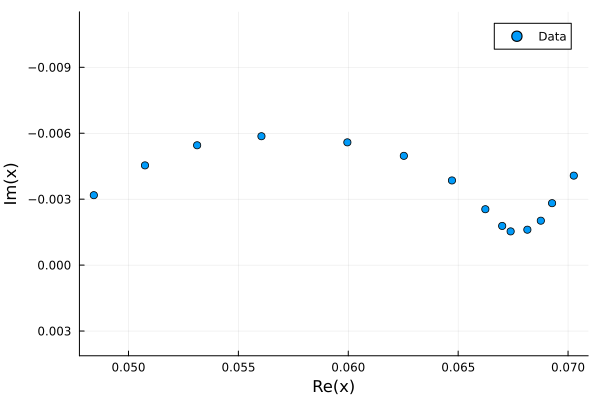

In [7]:
using CSV,DataFrames,Plots

omega_data =  [ 0.05, 0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]
Zs = CSV.read("Data/EIS_Data.csv",DataFrame)
Z_data = Zs[!,"Re(Z)"] -im*Zs[!,"-Im(Z)"]
data = [(omega_data,Z_data)]

scatter(Z_data,label = "Data",yflip=true,aspect_ratio=:equal)

rtol = 5.896197065237892e-7


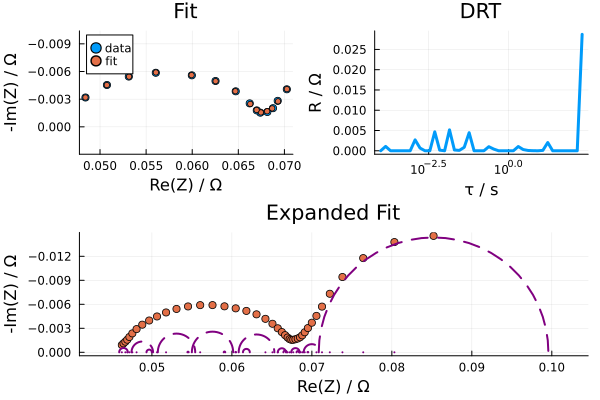

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.0702692-0.00409069im, 0.0693073-0.0027664im, 0.0686772-…
  "τ"   => LogRange{Float64}(0.0001, 200.0, 42)
  "R0"  => 0.0458644
  "drt" => [7.46734e-7, 0.00107422, 1.30051e-7, 9.46937e-9, 3.51434e-9, 1.78254…

In [8]:
fit = compute_drt(omega_data,Z_data)